In [67]:
import pandas as pd
import xarray as xr
import zipfile
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")



%matplotlib inline

path = os.getcwd()

### DEFINED FUNCTIONS

In [68]:
#unzip function
def unzip(z_file, model, print_info=True):
    with zipfile.ZipFile(z_file, 'r') as zip_ref:
        zip_ref.extractall(model)
        if print_info==True:
            print('Done with '+model+' model')
            
            
def rai(ds, dimension, method='ordinary'):
    ds_ma = ds.mean(dimension)
    
    ds_anom = ds - ds_ma
    
    if method.lower() == 'percentile':
        l_thresh = ds.reduce(np.nanpercentile,q=10,dim=dimension)
        u_thresh = ds.reduce(np.nanpercentile,q=90,dim=dimension)
        ds_low_10 = ds.where(ds<l_thresh).mean(dimension)
        ds_high_10 = ds.where(ds>u_thresh).mean(dimension)
    elif method.lower() == 'ordinary':
        thresh = ds.reduce(np.sort,dim=dimension)
        ds_low_10 = thresh[:10].mean(dimension)
        ds_high_10 = thresh[:-10:-1].mean(dimension)
    else:
        print('Wrong/No method selected.')
    
    
    negatives = -3*( (ds_anom.where(ds_anom<0)) / (ds_low_10-ds_ma) )
    positives = 3*( (ds_anom.where(ds_anom>0)) / (ds_high_10-ds_ma) )
    RAI = ds_anom.where(ds_anom>=0, negatives).where(ds_anom<0, positives)
    
    return RAI


def filtercounter(ds, x, y):
    return ds.where((ds > x) & (ds <= y)).count().values.tolist()

def filtermean(ds, x, y):
    return ds.where((ds > x) & (ds <= y)).reduce(np.nanmean).values.tolist()


def pointers(ax, num, percentage, linestyle = None, color = None, marker=None, marksize=None, label=None, show_legend=True):
    b=num
    pos=np.int_(b)+(np.ones(len(b))*4)
    perc = ['< -3', '-3', '-2', '-1', '', '1', '2', '3', '> 3']
    #pos = int(b)+4  #position of the whole number component of the number within the perc array.
    whole = (((pos)/(len(perc)-1))*np.pi)       #change whole part to angle
    bot = np.ones(len(b))*(len(perc)-1)
    bot1 = np.ones(len(b))*np.pi
    frac = ((b-np.int_(b))/bot)*bot1    #change fractional part to angle

    if color == None:
        ax.plot(np.pi-whole-frac,percentage,linestyle=linestyle, linewidth=2, marker = marker, markersize=marksize, label=label)
    else:
        ax.plot(np.pi-whole-frac,percentage,linestyle=linestyle, color=color, linewidth=5, marker = marker, markersize=marksize, label=label)
   
    ax.legend(loc=0, ncol=3, bbox_to_anchor=(1.25, 1))

    if show_legend==True:
        ax.legend(loc=0, ncol=3, bbox_to_anchor=(1.25, 1))
 


 #pointers(ax, [2,1.5,-2.75], we, color='r', marker = 'o', marksize=10, label='model1', show_legend=True)
#pointers(ax, [0.1,1.5,-2.75], [24,80,98], color='b', marker = '*', marksize=10, label='model2', show_legend=True)




In [69]:
station = ['Talensi', 10.66, -0.72]

models = ['access_cm2','bcc_csm2_mr','cesm2','cmcc_esm2','cnrm_cm6_1','cnrm_esm2_1','ec_earth3_veg_lr','fgoals_g3',
          'gfdl_esm4','hadgem3_gc31_ll','iitm_esm','inm_cm4_8','inm_cm5_0','ipsl_cm5a2_inca','ipsl_cm6a_lr','kace_1_0_g', 
          'miroc6','mpi_esm1_2_lr','miroc_es2l','mri_esm2_0','noresm2_mm','taiesm1','ukesm1_0_ll']
#'sam0_unicon',
models = sorted(models)

In [82]:
models

['access_cm2',
 'bcc_csm2_mr',
 'cesm2',
 'cmcc_esm2',
 'cnrm_cm6_1',
 'cnrm_esm2_1',
 'ec_earth3_veg_lr',
 'fgoals_g3',
 'gfdl_esm4',
 'hadgem3_gc31_ll',
 'iitm_esm',
 'inm_cm4_8',
 'inm_cm5_0',
 'ipsl_cm5a2_inca',
 'ipsl_cm6a_lr',
 'kace_1_0_g',
 'miroc6',
 'miroc_es2l',
 'mpi_esm1_2_lr',
 'mri_esm2_0',
 'noresm2_mm',
 'taiesm1',
 'ukesm1_0_ll']

### Generate bar plots of Rainfall anomalies(RAI) for various models in West Africa

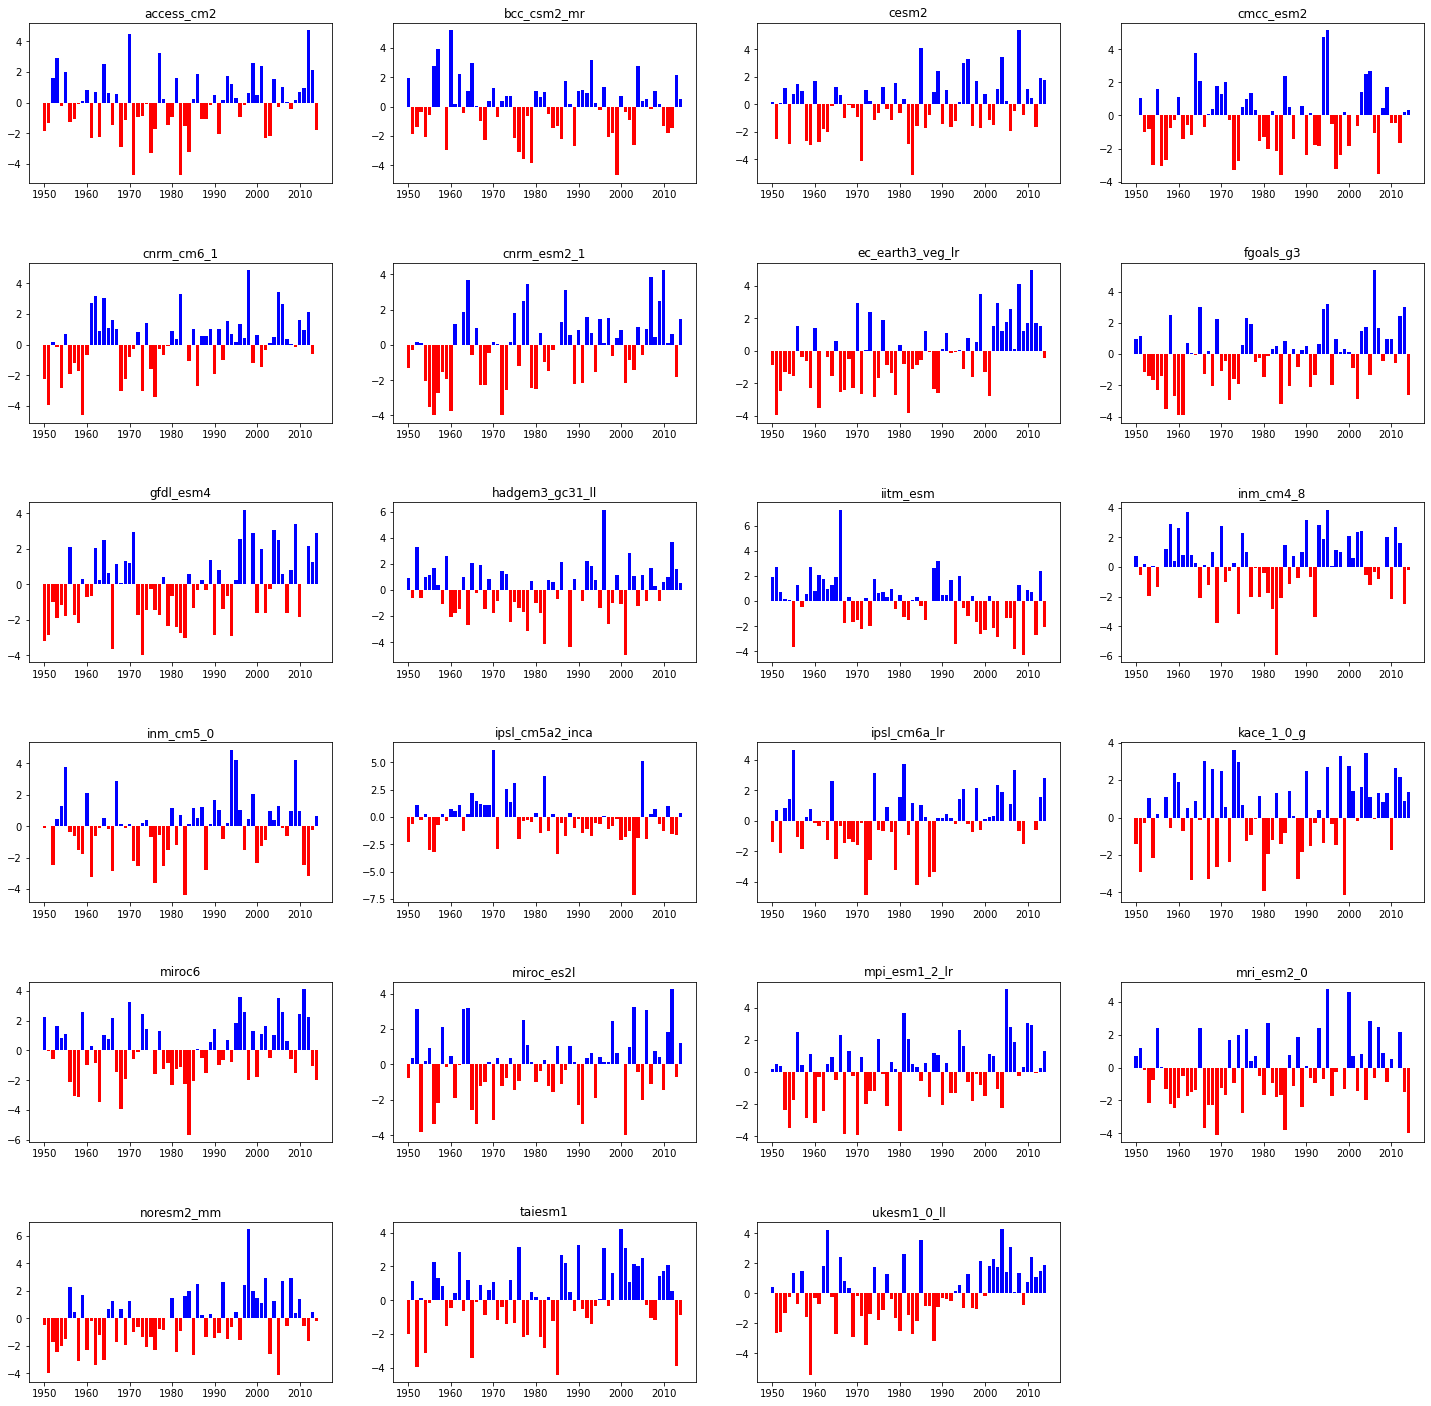

In [84]:
classification = ['Extremely Dry', 'Very Dry', 'Dry','Normal', 'Humid', 'Very Humid', 'Extremely Wet']
path = os.getcwd()
exp='historical'
ystart=1950; yend=2014

fig,axes = plt.subplots(ncols=len(models)//5, nrows=6, figsize=(25,25))
plt.subplots_adjust(hspace=0.5)
ax = axes.flatten()

final_count = {}
final_avg = {}
percentages={}
for i, mod in enumerate(models):
    #file = path+'/'+exp+'/'+mod+'*.zip'
    #print(i,mod)
    file = glob.glob(os.path.join(path,exp+'/*'+mod+'*.zip'))[0]
    data_file = glob.glob(os.path.join(path,mod+'/pr*'+exp+'*.nc'))[0]
    da_data = xr.open_dataset(data_file)
    da_RR = da_data.pr.sel(lon=slice(-17,17), lat=slice(4,20)).sel(time=slice(str(ystart),str(yend))).mean(['lon','lat']) * 86400   #convert rainfall from kg m-2 s-1 to mm/day
    a = da_RR.resample(time='1Y').sum('time')
    b = rai(a, 'time','ordinary')
    col_scheme = np.where(b.values>0, 'b','r')
    
    ax[i].bar(a['time.year'], b.values, color=col_scheme)
    ax[i].set_title(mod)
    
    count_val = []
    avg_val = []
    percentage_val=[]
    grouped_da_RAI = b
    for class_name in classification:
        if (class_name == 'Extremely Dry'):
            n = grouped_da_RAI.where((grouped_da_RAI <= -3)).count().values.tolist()
            n2 = grouped_da_RAI.where((grouped_da_RAI <= -3)).reduce(np.nanmean).values.tolist()
            count_val.append(n)
            avg_val.append(n2)
            
        elif( class_name == 'Very Dry'):
            n = filtercounter(grouped_da_RAI,-3,-2)
            n2 = filtermean(grouped_da_RAI,-3,-2)
            count_val.append(n)
            avg_val.append(n2)
          
        elif(class_name == 'Dry'):
            n = filtercounter(grouped_da_RAI,-2,-1)
            n2 = filtermean(grouped_da_RAI,-2,-1)
            count_val.append(n)
            avg_val.append(n2)
          
        elif(class_name == 'Normal'):
            n = grouped_da_RAI.where((grouped_da_RAI >-1) & (grouped_da_RAI< 1)).count().values.tolist()
            count_val.append(n)
            n2 = grouped_da_RAI.where((grouped_da_RAI > -1) & (grouped_da_RAI< 1)).reduce(np.nanmean).values.tolist()
            avg_val.append(n2)
          
        elif(class_name == 'Humid'):
            n = filtercounter(grouped_da_RAI,1,2)
            count_val.append(n)
            n2 = filtermean(grouped_da_RAI,1,2)
            avg_val.append(n2)
           
        elif(class_name == 'Very Humid'):
            n = filtercounter(grouped_da_RAI,2,3)
            count_val.append(n)
            n2 = filtermean(grouped_da_RAI,2,3)
            avg_val.append(n2)
          
        else:
            n =grouped_da_RAI.where((grouped_da_RAI >= 3)).count().values.tolist()
            count_val.append(n)
            n2 = grouped_da_RAI.where((grouped_da_RAI >= 3)).reduce(np.nanmean).values.tolist()
            avg_val.append(n2)
           
    
    final_count[mod] = count_val
    final_avg[mod] = avg_val
    percentages[mod]=percentage_val

        

fig.delaxes(ax[23])


### TABLE OF TOTAL COUNTS PER MODEL

In [71]:

count_data = pd.DataFrame(final_count).T
count_data.columns=classification

#count_data

### TABLE OF TOTAL AVERAGES PER MODEL

In [72]:
avg_data = pd.DataFrame(final_avg).T
avg_data.columns=classification
avg_data = avg_data.fillna(0)


### TABLE OF PERCENTAGES PER MODEL

In [73]:
percentage_data = pd.DataFrame(final_count).T
percentage_data.columns=classification
percentage_data = (count_data/max(count_data.sum(axis=1)))*100
#percentage_data


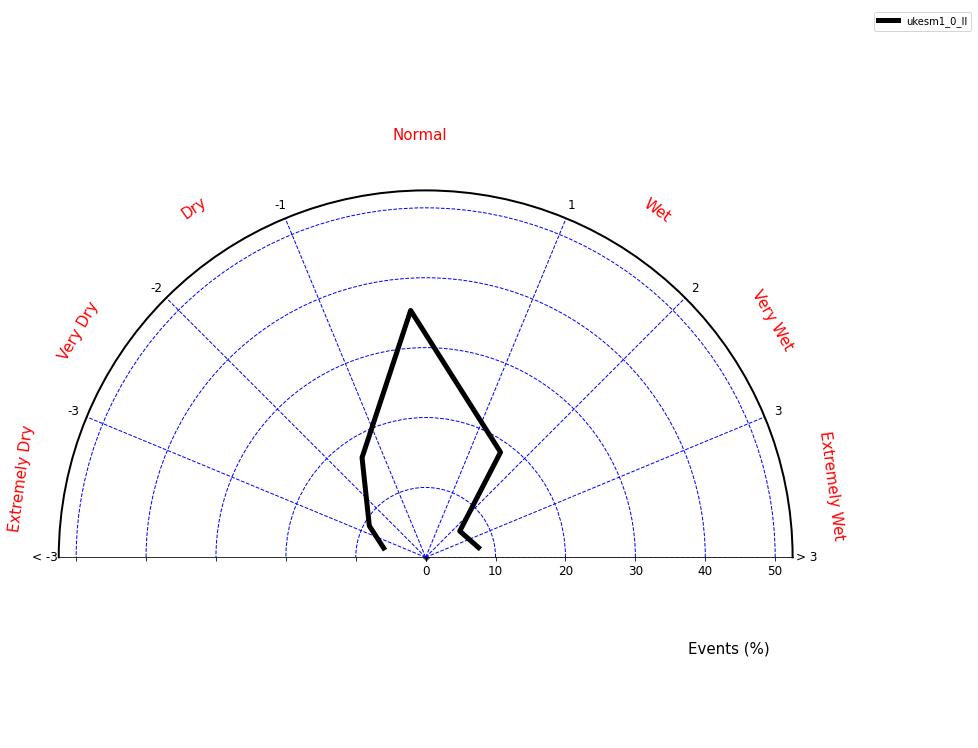

In [74]:
dx = 50
theta = np.linspace(0,np.pi,100)#*100
r = np.sin(theta)*(100-dx)

fig = plt.figure(figsize = (13.5,13.5))
ax = fig.add_subplot(111, polar=True)
c = ax.scatter(theta, r, c=r, s=20, cmap='Blues', alpha=0.0)

ax.set_thetamin(0)
ax.set_thetamax(180)

ax.set_yticks(np.arange(0,60.1,10),)#np.arange(-50,100.1,10))
ax.text( -0.35, 40, 'Events (%)', color='k', fontsize = 15)
ax.set_xticks(np.arange(0,np.pi+0.1,np.pi/8))

perc = ['< -3', '-3', '-2', '-1', '', '1', '2', '3', '> 3']
ax.set_xticklabels(perc[::-1])
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')

#Descriptors
ax.text( 1.65, 110-dx, 'Normal', color='r', fontsize = 15)
ax.text( 2.2, 110-dx, 'Dry', color='r', fontsize = 15, rotation=35)
ax.text( 2.65, 110-dx, 'Very Dry', color='r', fontsize = 15, rotation=60)
ax.text( 3.075, 110-dx, 'Extremely Dry', color='r', fontsize = 15, rotation=82.5)

ax.text( 1, 107-dx, 'Wet', color='r', fontsize = 15, rotation=-35)
ax.text( 0.57, 105-dx, 'Very Wet', color='r', fontsize = 15, rotation=-60)
ax.text( 0.05, 106-dx, 'Extremely Wet', color='r', fontsize = 15, rotation=-82.5)


ax.tick_params(axis='both', labelsize=12)
ax.spines['inner'].set_color('r')
ax.spines['polar'].set_linewidth(2)
#ax.spines['end'].set_linewidth(0)

ax.grid(True, which='major', axis='both', linestyle='--', color = 'b', linewidth=1)
ax.get_xgridlines()[4].set_linestyle('None')
ax.get_xgridlines()[-1].set_linestyle('None')
colors=['r']
markers = ['*','o','v','s','p']


pointers(ax, avg_data.iloc[0,:], percentage_data.iloc[0,:], color= 'k', linestyle = '-', marker = '', marksize=8, label=mod, show_legend=True)


In [75]:
avg_data.iloc[0,:]

Extremely Dry   -3.445046
Very Dry        -2.703302
Dry             -1.446332
Normal          -0.154846
Humid            1.575464
Very Humid       2.329972
Extremely Wet    3.536022
Name: access_cm2, dtype: float64

### 

In [76]:
avg_data.iloc[0].values

array([-3.44504629, -2.70330247, -1.44633228, -0.15484598,  1.57546374,
        2.32997188,  3.5360225 ])

In [77]:
percentage_data.iloc[0].values

array([ 6.15384615,  9.23076923, 16.92307692, 35.38461538, 18.46153846,
        6.15384615,  7.69230769])